In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalize pixel values to range [0,1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert labels to categorical format
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# Print dataset shape
print(f"Training data shape: {x_train.shape}, Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}, Test labels shape: {y_test.shape}")


170498071/170498071 [==============================] - 162s 1us/step
Training data shape: (50000, 32, 32, 3), Training labels shape: (50000, 10)
Test data shape: (10000, 32, 32, 3), Test labels shape: (10000, 10)


In [4]:
def build_cnn_model():
    model = keras.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')  # 10 classes for CIFAR-10
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Build the CNN model
cnn_model = build_cnn_model()


In [5]:
history = cnn_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=64)


Epoch 1/10
782/782 [==============================] - 47s 58ms/step - loss: 1.5254 - accuracy: 0.4440 - val_loss: 1.3187 - val_accuracy: 0.5322
Epoch 2/10
782/782 [==============================] - 46s 59ms/step - loss: 1.1653 - accuracy: 0.5875 - val_loss: 1.1074 - val_accuracy: 0.6068
Epoch 3/10
782/782 [==============================] - 47s 60ms/step - loss: 1.0035 - accuracy: 0.6490 - val_loss: 1.0189 - val_accuracy: 0.6441
Epoch 4/10
782/782 [==============================] - 44s 56ms/step - loss: 0.8841 - accuracy: 0.6913 - val_loss: 1.0124 - val_accuracy: 0.6440
Epoch 5/10
782/782 [==============================] - 43s 55ms/step - loss: 0.8001 - accuracy: 0.7216 - val_loss: 0.8934 - val_accuracy: 0.6861
Epoch 6/10
782/782 [==============================] - 44s 57ms/step - loss: 0.7183 - accuracy: 0.7488 - val_loss: 0.8716 - val_accuracy: 0.6999
Epoch 7/10
782/782 [==============================] - 51s 66ms/step - loss: 0.6561 - accuracy: 0.7698 - val_loss: 0.8622 - val_accuracy:

In [6]:
test_loss, test_acc = cnn_model.evaluate(x_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

313/313 - 4s - loss: 0.8565 - accuracy: 0.7200 - 4s/epoch - 13ms/step
Test Accuracy: 72.00%


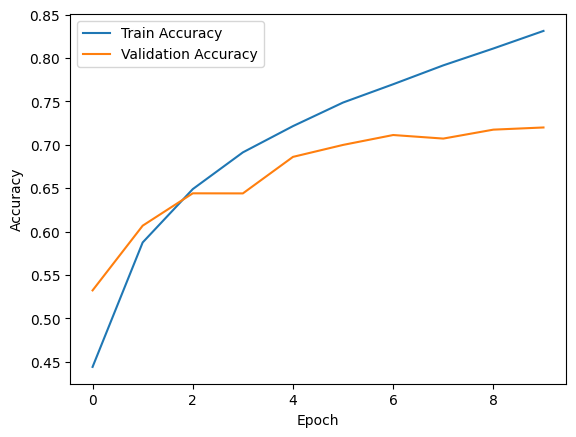

In [7]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [8]:
# Save the trained model
cnn_model.save("cnn_singularity_analysis.h5")
print("Model saved successfully!")


Model saved successfully!


D:\CNN-Singularity-Analysis\cnn\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
# Load the trained model
model = tf.keras.models.load_model("cnn_singularity_analysis.h5")  # Update with your model path

# Function to compute condition number of a weight matrix
def compute_condition_numbers(model):
    condition_numbers = {}
    
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense):
            weights = layer.get_weights()
            if len(weights) > 0:
                W = weights[0]  # Extract weight matrix
                W_reshaped = W.reshape(W.shape[0], -1)  # Reshape for SVD
                singular_values = np.linalg.svd(W_reshaped, compute_uv=False)
                cond_number = max(singular_values) / min(singular_values)
                condition_numbers[layer.name] = cond_number
    
    return condition_numbers

# Compute and display condition numbers
cond_nums = compute_condition_numbers(model)
for layer, cond in cond_nums.items():
    print(f"Layer: {layer}, Condition Number: {cond:.2f}")


Layer: conv2d, Condition Number: 1.44
Layer: conv2d_1, Condition Number: 1.67
Layer: conv2d_2, Condition Number: 1.85
Layer: dense, Condition Number: 7.90
Layer: dense_1, Condition Number: 1.80


In [10]:
# Function to compute singular values for each layer
def compute_singular_values(model):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense):
            weights, _ = layer.get_weights()  # Get layer weights
            u, s, v = np.linalg.svd(weights.reshape(weights.shape[0], -1), full_matrices=False)  # Compute SVD
            print(f"Layer: {layer.name}, Singular Values: {s}")

# Compute singular values for CNN model
compute_singular_values(cnn_model)


Layer: conv2d, Singular Values: [2.3253338 2.101961  1.6184943]
Layer: conv2d_1, Singular Values: [10.747375  8.649925  6.441575]
Layer: conv2d_2, Singular Values: [18.394474 14.279444  9.967908]
Layer: dense, Singular Values: [9.231657  8.502823  8.319624  7.981483  7.7000895 7.5456705 7.354821
 7.1721215 6.8456984 5.665809  4.988002  4.8363934 4.758827  4.5152345
 4.366886  4.319828  4.1210938 4.0767503 3.9824748 3.8240879 3.6220806
 3.490015  3.4599755 3.4307    3.4201055 3.3213625 3.2656655 3.2308407
 3.104052  3.0885918 3.044025  2.9601383 2.8783138 2.859776  2.8144553
 2.8102899 2.7427688 2.7420015 2.6927934 2.6536796 2.6079369 2.599421
 2.5683968 2.5118704 2.4702215 2.4228365 2.3956344 2.3487072 2.322072
 2.299422  2.2663014 2.2195413 2.1755483 2.1551113 2.1424446 2.1174045
 2.097293  2.0848079 2.0522816 2.0327876 2.0180328 1.9811862 1.9492407
 1.9065256 1.9003626 1.8772445 1.8327014 1.7789556 1.7617997 1.7205132
 1.6830187 1.6647387 1.624041  1.6000015 1.5861839 1.5783974 1.575

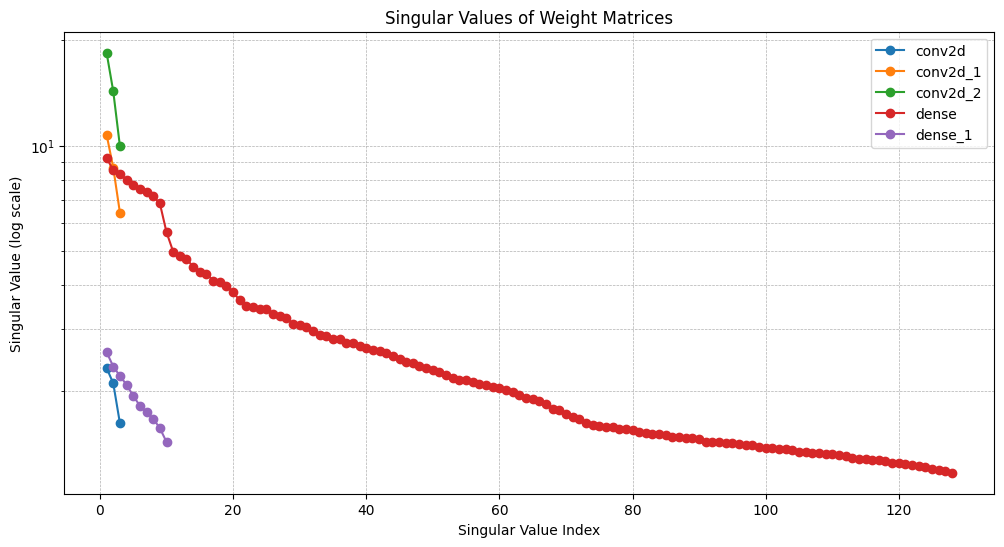

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot singular values
def plot_singular_values(model):
    plt.figure(figsize=(12, 6))
    
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense):
            weights, _ = layer.get_weights()
            u, s, v = np.linalg.svd(weights.reshape(weights.shape[0], -1), full_matrices=False)
            
            plt.plot(range(1, len(s) + 1), s, marker='o', linestyle='-', label=f'{layer.name}')
    
    plt.yscale('log')  # Log scale for better visualization
    plt.xlabel('Singular Value Index')
    plt.ylabel('Singular Value (log scale)')
    plt.title('Singular Values of Weight Matrices')
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

# Call the function to plot
plot_singular_values(cnn_model)


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

# Define regularization strength
l2_reg = 1e-4  

# Optimized Model
model = Sequential([
    # Conv Layers with Batch Normalization & L2 Regularization
    Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(l2_reg), input_shape=(32, 32, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),  # Downsampling
    
    Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),  # Downsampling
    
    Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    
    # Replace Flatten() with GlobalAveragePooling
    GlobalAveragePooling2D(),
    
    # Fully Connected Layers with Dropout
    Dense(128, activation='relu', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    Dropout(0.5),  
    
    Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(10, activation='softmax')  # Output layer (adjust as needed)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_10 (Ba  (None, 30, 30, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 batch_normalization_11 (Ba  (None, 13, 13, 64)        256       
 tchNormalization)                                               
                                                      

In [22]:
x_train_resized = tf.image.resize(x_train, (64, 64))
x_test_resized = tf.image.resize(x_test, (64, 64))

In [23]:
history = model.fit(x_train, y_train, 
                    validation_data=(x_test, y_test), 
                    epochs=50, 
                    batch_size=32)


Epoch 1/50
1563/1563 [==============================] - 468s 297ms/step - loss: 1.7962 - accuracy: 0.3807 - val_loss: 1.7017 - val_accuracy: 0.4290
Epoch 2/50
1563/1563 [==============================] - 97s 62ms/step - loss: 1.3364 - accuracy: 0.5458 - val_loss: 1.1769 - val_accuracy: 0.6009
Epoch 3/50
1563/1563 [==============================] - 99s 63ms/step - loss: 1.1797 - accuracy: 0.6123 - val_loss: 1.4531 - val_accuracy: 0.5161
Epoch 4/50
1563/1563 [==============================] - 102s 65ms/step - loss: 1.0742 - accuracy: 0.6578 - val_loss: 1.3388 - val_accuracy: 0.5637
Epoch 5/50
1563/1563 [==============================] - 101s 65ms/step - loss: 1.0049 - accuracy: 0.6869 - val_loss: 1.0443 - val_accuracy: 0.6579
Epoch 6/50
1563/1563 [==============================] - 100s 64ms/step - loss: 0.9493 - accuracy: 0.7122 - val_loss: 1.1000 - val_accuracy: 0.6566
Epoch 7/50
1563/1563 [==============================] - 102s 65ms/step - loss: 0.8986 - accuracy: 0.7327 - val_loss: 0.

In [27]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

313/313 - 6s - loss: 1.0929 - accuracy: 0.7490 - 6s/epoch - 18ms/step
Test Accuracy: 74.90%


In [29]:
model.save("cnn_singularity_analysis_v2.h5")
print("Model saved successfully!")

Model saved successfully!


In [30]:
# Load the trained model
model = tf.keras.models.load_model("cnn_singularity_analysis_v2.h5")  # Update with your model path

# Function to compute condition number of a weight matrix
def compute_condition_numbers(model):
    condition_numbers = {}
    
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense):
            weights = layer.get_weights()
            if len(weights) > 0:
                W = weights[0]  # Extract weight matrix
                W_reshaped = W.reshape(W.shape[0], -1)  # Reshape for SVD
                singular_values = np.linalg.svd(W_reshaped, compute_uv=False)
                cond_number = max(singular_values) / min(singular_values)
                condition_numbers[layer.name] = cond_number
    
    return condition_numbers

# Compute and display condition numbers
cond_nums = compute_condition_numbers(model)
for layer, cond in cond_nums.items():
    print(f"Layer: {layer}, Condition Number: {cond:.2f}")


Layer: conv2d_9, Condition Number: 1.61
Layer: conv2d_10, Condition Number: 1.55
Layer: conv2d_11, Condition Number: 1.18
Layer: dense_8, Condition Number: 1911.49
Layer: dense_9, Condition Number: 17.08
Layer: dense_10, Condition Number: 2.49


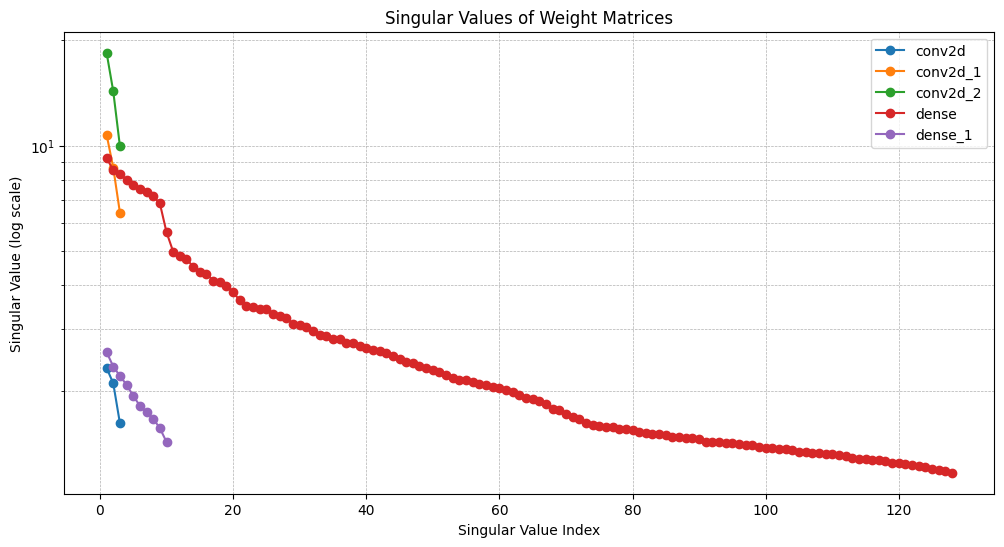

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot singular values
def plot_singular_values(model):
    plt.figure(figsize=(12, 6))
    
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense):
            weights, _ = layer.get_weights()
            u, s, v = np.linalg.svd(weights.reshape(weights.shape[0], -1), full_matrices=False)
            
            plt.plot(range(1, len(s) + 1), s, marker='o', linestyle='-', label=f'{layer.name}')
    
    plt.yscale('log')  # Log scale for better visualization
    plt.xlabel('Singular Value Index')
    plt.ylabel('Singular Value (log scale)')
    plt.title('Singular Values of Weight Matrices')
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

# Call the function to plot
plot_singular_values(cnn_model)


In [32]:
compute_singular_values(model)

Layer: conv2d_9, Singular Values: [4.814892  4.227573  2.9828775]
Layer: conv2d_10, Singular Values: [14.660151 12.615271  9.461147]
Layer: conv2d_11, Singular Values: [22.598362 21.711174 19.082047]
Layer: dense_8, Singular Values: [5.59159040e+00 5.21487045e+00 5.18485403e+00 4.98128271e+00
 4.85871315e+00 4.49014854e+00 4.30087376e+00 4.16485834e+00
 4.04216290e+00 1.52152920e+00 1.23241961e+00 1.15757275e+00
 1.12298810e+00 1.10239708e+00 1.08915591e+00 1.05637598e+00
 1.03543901e+00 1.01889002e+00 1.00113940e+00 9.91304517e-01
 9.71308589e-01 9.54607725e-01 9.38475072e-01 9.26677227e-01
 8.95390689e-01 8.85648251e-01 8.78717721e-01 8.70557666e-01
 8.58516157e-01 8.49070668e-01 8.18619728e-01 8.11611950e-01
 8.08234394e-01 7.95140266e-01 7.82696545e-01 7.67425358e-01
 7.52067208e-01 7.40266442e-01 7.32535720e-01 7.27819800e-01
 7.19015837e-01 7.15237498e-01 7.08626151e-01 6.88790858e-01
 6.74497545e-01 6.66923285e-01 6.55744553e-01 6.45689905e-01
 6.42056227e-01 6.37818396e-01 6.26